# Dataset: COVIDx CXR3 (train: 29.986, test: 400)
# link dataset: https://www.kaggle.com/datasets/andyczhao/covidx-cxr2
# 1. Phan chia anh theo nhan: Positivite va Negative (train: 15.994 Posi va 13.992 Neg; test: 200 Posi, 200 Neg)
# 2. Phan chia train/test thanh train/val/test (23.988/5.998/400)

In [1]:
#importing the libraries
import torch
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from PIL import Image
from torch.utils.data import DataLoader
from tqdm import tqdm
import albumentations  as A
from albumentations.pytorch.transforms import ToTensorV2
from torch.utils.data import Dataset
import cv2
import os
import os.path as path
import shutil
import matplotlib.pyplot as plt

import sys
sys.path.insert(0, '../dataloader/')
from datasetCOVIDx import ImageDataset, LungImageDataset


/home/trucloan/anaconda3/envs/myenv/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# tao duong dan den data
data_path = '../../../dataset/COVIDxCXR3/'

train_path = data_path + 'train/'
test_path = data_path + 'test/'

In [3]:
# doc file metadata
train_metadata = data_path + 'train.txt'
test_metadata = data_path + 'test.txt'
train_txt= pd.read_csv(train_metadata, sep=" ", header=None)
test_txt = pd.read_csv(test_metadata, sep=" ", header=None)

In [4]:
# gan ten cot
train_txt.columns= ["patient id","file_name","class","source"]
train_txt.head()

,patient id,file_name,class,source
0,5,ARDSSevere.png,negative,cohen
1,25,acute-respiratory-distress-syndrome-ards-1.jpg,negative,cohen
2,26,acute-respiratory-distress-syndrome-ards.jpg,negative,cohen
3,27,ards-secondary-to-tiger-snake-bite.png,negative,cohen
4,28,pneumocystis-pneumonia-2-PA.png,negative,cohen


In [6]:
# https://www.dataquest.io/blog/tutorial-add-column-pandas-dataframe-based-on-if-else-condition/
train_txt['label'] = np.where(train_txt['class']== 'negative', 0, 1) # tao cot label theo dk cua class
train_txt

,patient id,file_name,class,source,label
0,5,ARDSSevere.png,negative,cohen,0
1,25,acute-respiratory-distress-syndrome-ards-1.jpg,negative,cohen,0
2,26,acute-respiratory-distress-syndrome-ards.jpg,negative,cohen,0
3,27,ards-secondary-to-tiger-snake-bite.png,negative,cohen,0
4,28,pneumocystis-pneumonia-2-PA.png,negative,cohen,0
...,...,...,...,...,...
29981,55204bb8-89fc-449d-8563-e91654abea9d,55204bb8-89fc-449d-8563-e91654abea9d.png,negative,rsna,0
29982,0f4b80b6-fd39-451f-aebf-7cdb1b655c0b,0f4b80b6-fd39-451f-aebf-7cdb1b655c0b.png,negative,rsna,0
29983,5fb64e85-62ef-4852-8ad1-f799015c8cc3,5fb64e85-62ef-4852-8ad1-f799015c8cc3.png,negative,rsna,0
29984,c57ad4fd-3aa8-4ae8-a262-7336360d8265,c57ad4fd-3aa8-4ae8-a262-7336360d8265.png,negative,rsna,0


In [7]:
# chi lay cot filename va label (1,4)
train_txt1 = train_txt.iloc[:,[1,4]]
train_txt1

,file_name,label
0,ARDSSevere.png,0
1,acute-respiratory-distress-syndrome-ards-1.jpg,0
2,acute-respiratory-distress-syndrome-ards.jpg,0
3,ards-secondary-to-tiger-snake-bite.png,0
4,pneumocystis-pneumonia-2-PA.png,0
...,...,...
29981,55204bb8-89fc-449d-8563-e91654abea9d.png,0
29982,0f4b80b6-fd39-451f-aebf-7cdb1b655c0b.png,0
29983,5fb64e85-62ef-4852-8ad1-f799015c8cc3.png,0
29984,c57ad4fd-3aa8-4ae8-a262-7336360d8265.png,0


In [4]:
# gan ten cot tren file test
test_txt.columns= ["patient id","file_name","class","source"]
test_txt.head()

,patient id,file_name,class,source
0,419639-003251,MIDRC-RICORD-1C-419639-003251-46647-0.png,positive,ricord
1,419639-001464,MIDRC-RICORD-1C-419639-001464-39871-0.png,positive,ricord
2,419639-000918,MIDRC-RICORD-1C-419639-000918-78965-0.png,positive,ricord
3,419639-003318,MIDRC-RICORD-1C-419639-003318-64285-0.png,positive,ricord
4,419639-001015,MIDRC-RICORD-1C-419639-001015-81591-0.png,positive,ricord


In [5]:
# tao cot label theo dk cua class
test_txt['label'] = np.where(test_txt['class']== 'negative', 0, 1) 
test_txt

,patient id,file_name,class,source,label
0,419639-003251,MIDRC-RICORD-1C-419639-003251-46647-0.png,positive,ricord,1
1,419639-001464,MIDRC-RICORD-1C-419639-001464-39871-0.png,positive,ricord,1
2,419639-000918,MIDRC-RICORD-1C-419639-000918-78965-0.png,positive,ricord,1
3,419639-003318,MIDRC-RICORD-1C-419639-003318-64285-0.png,positive,ricord,1
4,419639-001015,MIDRC-RICORD-1C-419639-001015-81591-0.png,positive,ricord,1
...,...,...,...,...,...
395,a77b32f6-1999-4cc6-8a0d-1ef7e53850f0,a77b32f6-1999-4cc6-8a0d-1ef7e53850f0.png,negative,rsna,0
396,41bf2042-53a2-44a8-9a29-55e643af5ac0,41bf2042-53a2-44a8-9a29-55e643af5ac0.png,negative,rsna,0
397,ec09ddb3-9b0b-4749-9e0d-f94a4a7e5fed,ec09ddb3-9b0b-4749-9e0d-f94a4a7e5fed.png,negative,rsna,0
398,abff4044-3c0a-458f-b0c7-04254be7fc0c,abff4044-3c0a-458f-b0c7-04254be7fc0c.png,negative,rsna,0


In [6]:
# chi lay cot filename va label (1,4)
test_txt1 = test_txt.iloc[:,[1,4]]
test_txt1

,file_name,label
0,MIDRC-RICORD-1C-419639-003251-46647-0.png,1
1,MIDRC-RICORD-1C-419639-001464-39871-0.png,1
2,MIDRC-RICORD-1C-419639-000918-78965-0.png,1
3,MIDRC-RICORD-1C-419639-003318-64285-0.png,1
4,MIDRC-RICORD-1C-419639-001015-81591-0.png,1
...,...,...
395,a77b32f6-1999-4cc6-8a0d-1ef7e53850f0.png,0
396,41bf2042-53a2-44a8-9a29-55e643af5ac0.png,0
397,ec09ddb3-9b0b-4749-9e0d-f94a4a7e5fed.png,0
398,abff4044-3c0a-458f-b0c7-04254be7fc0c.png,0


In [7]:
# Ghi file CSV
test_txt1.to_csv(data_path + 't.csv',index=False) 

In [8]:
with open(data_path + 'test_set.txt', 'w') as f:
    f.write(
        test_txt1.to_string(header = False, index = False)
    )
f.close()

# 1. Phan chia anh thanh 2 thu muc Positive va Negative

In [ ]:
# tạo 2 thư mục chứa ảnh phân vùng theo nhãn (Positive - Negative)
path_label = [data_path + 'EDA_Train/Negative/', data_path + 'EDA_Train/Positive/'] 

for i in range(len(path_label)):
    if not path.exists(path_label[i]): 
        os.mkdir(path_label[i])

In [9]:
# tạo 2 thư mục chứa ảnh phân vùng theo nhãn (Positive - Negative)
path_label = [data_path + 'EDA_Test/Negative/', data_path + 'EDA_Test/Positive/'] 

for i in range(len(path_label)):
    if not path.exists(path_label[i]): 
        os.mkdir(path_label[i])

In [ ]:
# copy ảnh tải về phân chia vào từng thư mục theo label
source = train_path
for i in range(len(train_txt)):
    if (train_txt['label'][i] ==0):
        shutil.copy(source + train_txt['file_name'][i], path_label[0])
    elif (train_txt['label'][i] == 1):
        shutil.copy(source + train_txt['file_name'][i], path_label[1])

In [10]:
#copy ảnh tải về phân chia vào từng thư mục theo label
source = test_path
for i in range(len(test_txt)):
    if (test_txt['label'][i] ==0):
        shutil.copy(source + test_txt['file_name'][i], path_label[0])
    elif (test_txt['label'][i] == 1):
        shutil.copy(source + test_txt['file_name'][i], path_label[1])

In [11]:
for i in range(len(path_label)):
    print(path_label[i], len(os.listdir(path_label[i]))) # xem có bao nhiêu file trong thư mục

../../../dataset/COVIDxCXR3/EDA_Test/Negative/ 200
../../../dataset/COVIDxCXR3/EDA_Test/Positive/ 200


# 2. Phan chia tran thanh train/ validation

In [10]:
train_set,val_set=train_test_split(train_txt1,test_size=0.2, random_state = 42, shuffle=True)

In [11]:
train_set

,file_name,label
17557,A264703-01-02-1901-NA-CHEST_AP_PORT-66725-2.00...,1
618,12941_2020_358_Fig1_HTML.jpg,1
17084,A073761-01-12-1901-NA-CHEST_AP_PORTABLE-71927-...,1
22586,A071880-12-31-1900-NA-CHEST_AP_PORT-70474-4.00...,1
26947,A485373-01-05-1901-NA-CHEST_AP_PORT-97503-4.00...,1
...,...,...
29802,46480de3-b915-4868-bd15-1e2c728b540b.png,0
5390,7462adfa-a0fc-4489-8d58-89f1d012c26a.png,0
860,COVID(151).png,1
15795,1ffee791-10f6-4b8f-bfcd-35220e8e0003.png,0


In [ ]:
with open(data_path + 'train_set.txt', 'w') as f:
    f.write(
        train_set.to_string(header = False, index = False)
    )
f.close()

In [ ]:
val_set

,file_name,label
26351,A504821-01-04-1901-NA-CHEST_AP_VIEWONLY-43696-...,1
7568,af387f75-2b11-4210-8ca5-aeae34b354c5.png,0
21818,A492240-01-09-1901-NA-CHEST_AP_PORTABLE-64102-...,1
5199,6de2cc0e-1591-4974-9bed-9cb29727753b.png,0
21871,A134763-01-01-1901-NA-CHEST_AP_PORT-30237-1.00...,1
...,...,...
23627,A969170-12-31-1900-NA-CHEST_AP_VIEWONLY-23879-...,1
11405,383d8991-e27b-4f43-bab1-e1f492ace0f5.png,0
29157,A030428-01-03-1901-NA-CHEST_AP_PORT-06922-1.00...,1
18757,A370011-01-24-1901-NA-CHEST_AP_VIEWONLY-84157-...,1


In [ ]:
with open(data_path + 'val_set.txt', 'w') as f:
    f.write(
        val_set.to_string(header = False, index = False)
    )
f.close()

In [ ]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23988 entries, 17557 to 23654
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  23988 non-null  object
 1   label      23988 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 562.2+ KB


No handles with labels found to put in legend.


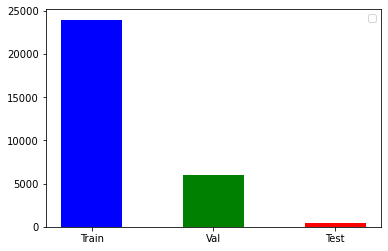

In [ ]:
# ve phan bo data tren train, val, test
# https://stackabuse.com/matplotlib-bar-plot-tutorial-and-examples/
# https://www.tutorialspoint.com/matplotlib/matplotlib_bar_plot.htm


len_train , len_val, len_test = len(train_set), len(val_set), len(test_txt)

# print(len_train , len_val, len_test)
x = ['Train', 'Val', 'Test']
y = [len_train, len_val, len_test]
plt.bar(x, y, color = ['b', 'g', 'r'], width=0.5)
plt.legend()
plt.savefig('../../../result/classification/visualize/DistributeTrainValTest.png', bbox_inches='tight')
plt.show()

In [ ]:
lst_train = list(train_set['label'].value_counts())
lst_val = list(val_set['label'].value_counts())
lst_test = list(test_txt1['label'].value_counts())
lst_test

[200, 200]

In [ ]:
def visualize_distribute_dataset(lst_train, lst_val, lst_test, path):
    y = [lst_train, lst_val, lst_test]
    # set width of bar
    barWidth = 0.25


    data = np.array(y).T.tolist()

    X = np.arange(3)
    fig = plt.figure()
    ax = fig.add_axes([0,0, 1,2])

    covid = ax.bar(X + 0.00, data[0], color = 'r', width = 0.25, label = 'Positive')

    normal = ax.bar(X + 0.25, data[1], color = 'b', width = 0.25, label = 'Negative')

    # Adding Xticks
    plt.xlabel('Dataset', fontweight ='bold', fontsize = 15)
    plt.ylabel('Total images', fontweight ='bold', fontsize = 15)
    plt.xticks([r + barWidth for r in range(len(X))],
            ['Train', 'Val', 'Test'])

    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(covid)
    autolabel(normal)
    plt.title('Distribution of data sources')
    plt.legend()

    # saving the file.Make sure you 
    # use savefig() before show()
    plt.savefig(path, bbox_inches='tight')
    plt.show()

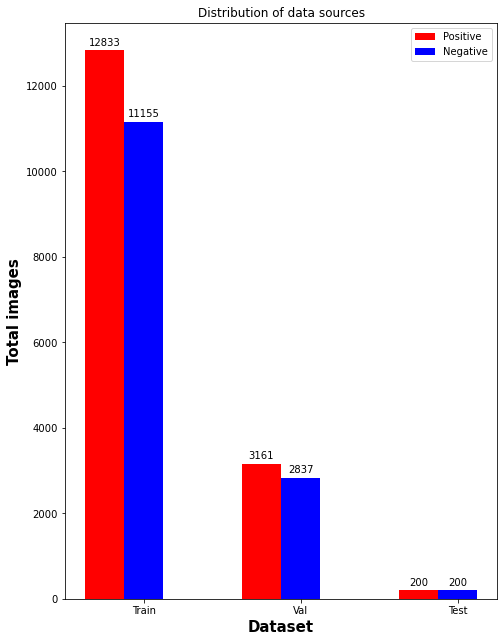

In [ ]:
visualize_distribute_dataset(lst_train, lst_val, lst_test, '../../../result/classification/visualize/DistributeDatasetPosNeg.png')


# 3. Visualize CXR, Lung, CXR without Lung

In [ ]:
import torchvision.transforms as transforms


def augment():
    data_transforms = {
        'train' : transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((256, 256)),
            transforms.RandomAffine(degrees = 0, shear = 0.2),    
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean = [0.485, 0.456, 0.406],  std = np.array([0.229, 0.224, 0.225])),
        ]),
        'val' : transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((256,256)),
            transforms.ToTensor(),
            transforms.Normalize(mean = [0.485, 0.456, 0.406],  std = np.array([0.229, 0.224, 0.225]))
        ]),
        'test' : transforms.Compose([
            transforms.Resize((256,256)),
            transforms.ToTensor(),
            transforms.Normalize(mean = [0.485, 0.456, 0.406],  std = np.array([0.229, 0.224, 0.225]))
        ])
    }
    return data_transforms

In [ ]:
def imshow_img_mask1(img, mask, maskthres, lung, notlung, targets, name):
    """ Imshow for Tensor """
    plt.figure(figsize = (30,10))
    for idx in range(2):   
           
        newlabel = ['Negative' if lb == 0 else 'Positive' for lb in targets]

        plt.subplot(2,10, 1+idx*10)
        plt.imshow(img[idx], cmap='gray')   

        plt.subplot(2,10, 2+idx*10)
        plt.imshow(mask[idx], cmap='gray')

        plt.subplot(2,10, 3+idx*10)
        plt.imshow(lung[idx], cmap='gray')
        plt.title(name[idx] + ' ('+ newlabel[idx] + ')')

        plt.subplot(2,10, 4+idx*10)
        plt.imshow(maskthres[idx], cmap= 'binary')            

        plt.subplot(2,10,5+idx*10)
        plt.imshow(notlung[idx], cmap = 'gray')

        plt.subplot(2,10,6+idx*10)
        plt.imshow(img[idx +2], cmap='gray')
              

        plt.subplot(2,10, 7+idx*10)
        plt.imshow(mask[idx +2], cmap='gray')  

        plt.subplot(2,10, 8+idx*10)
        plt.imshow(lung[idx + 2], cmap='gray')
        plt.title(name[idx+2]  +' (' + newlabel[idx+2] + ')')        

        plt.subplot(2,10, 9+idx*10)
        plt.imshow(maskthres[idx+2],cmap= 'binary')
        # plt.title(newlabel[idx+2])

        plt.subplot(2,10, 10+idx*10)
        plt.imshow(notlung[idx+2], cmap='gray')

    plt.savefig('/mnt/DATA/covid19_resnet152_python-main/archive_14gb/mainscript/classification/visualize/train_dataloader.png')

    plt.show()


In [ ]:
def img_de_normalize (img, mask):
        
    img = np.squeeze(img)
    img = img*0.2220 + 0.5128
    mask = mask*0.220+0.5128
    img= np.clip(img, 0, 1)
    mask = np.clip(mask, 0,1)
    
    return img, mask

In [15]:
# train_txt11= pd.read_csv('/mnt/DATA/research/classificationCOVID19applyseg/dataset/COVIDxCXR3/metadata/train_set.txt', sep= '\s+', header=None)
# train_txt11.columns = ['file_name', 'label']
# train_txt11

,file_name,label
0,A264703-01-02-1901-NA-CHEST_AP_PORT-66725-2.00...,1
1,12941_2020_358_Fig1_HTML.jpg,1
2,A073761-01-12-1901-NA-CHEST_AP_PORTABLE-71927-...,1
3,A071880-12-31-1900-NA-CHEST_AP_PORT-70474-4.00...,1
4,A485373-01-05-1901-NA-CHEST_AP_PORT-97503-4.00...,1
...,...,...
23983,46480de3-b915-4868-bd15-1e2c728b540b.png,0
23984,7462adfa-a0fc-4489-8d58-89f1d012c26a.png,0
23985,COVID(151).png,1
23986,1ffee791-10f6-4b8f-bfcd-35220e8e0003.png,0


In [16]:
train_set

,file_name,label
17557,A264703-01-02-1901-NA-CHEST_AP_PORT-66725-2.00...,1
618,12941_2020_358_Fig1_HTML.jpg,1
17084,A073761-01-12-1901-NA-CHEST_AP_PORTABLE-71927-...,1
22586,A071880-12-31-1900-NA-CHEST_AP_PORT-70474-4.00...,1
26947,A485373-01-05-1901-NA-CHEST_AP_PORT-97503-4.00...,1
...,...,...
29802,46480de3-b915-4868-bd15-1e2c728b540b.png,0
5390,7462adfa-a0fc-4489-8d58-89f1d012c26a.png,0
860,COVID(151).png,1
15795,1ffee791-10f6-4b8f-bfcd-35220e8e0003.png,0


In [17]:
val_set

,file_name,label
26351,A504821-01-04-1901-NA-CHEST_AP_VIEWONLY-43696-...,1
7568,af387f75-2b11-4210-8ca5-aeae34b354c5.png,0
21818,A492240-01-09-1901-NA-CHEST_AP_PORTABLE-64102-...,1
5199,6de2cc0e-1591-4974-9bed-9cb29727753b.png,0
21871,A134763-01-01-1901-NA-CHEST_AP_PORT-30237-1.00...,1
...,...,...
23627,A969170-12-31-1900-NA-CHEST_AP_VIEWONLY-23879-...,1
11405,383d8991-e27b-4f43-bab1-e1f492ace0f5.png,0
29157,A030428-01-03-1901-NA-CHEST_AP_PORT-06922-1.00...,1
18757,A370011-01-24-1901-NA-CHEST_AP_VIEWONLY-84157-...,1


In [ ]:
# val_txt11= pd.read_csv('/mnt/DATA/covid19_resnet152_python-main/archive_14gb/COVIDxCXR3/val_set.txt', sep= '\s+', header=None)
# val_txt11.columns = ['file_name', 'label']
# val_txt11

,file_name,label
0,A504821-01-04-1901-NA-CHEST_AP_VIEWONLY-43696-...,1
1,af387f75-2b11-4210-8ca5-aeae34b354c5.png,0
2,A492240-01-09-1901-NA-CHEST_AP_PORTABLE-64102-...,1
3,6de2cc0e-1591-4974-9bed-9cb29727753b.png,0
4,A134763-01-01-1901-NA-CHEST_AP_PORT-30237-1.00...,1
...,...,...
5993,A969170-12-31-1900-NA-CHEST_AP_VIEWONLY-23879-...,1
5994,383d8991-e27b-4f43-bab1-e1f492ace0f5.png,0
5995,A030428-01-03-1901-NA-CHEST_AP_PORT-06922-1.00...,1
5996,A370011-01-24-1901-NA-CHEST_AP_VIEWONLY-84157-...,1


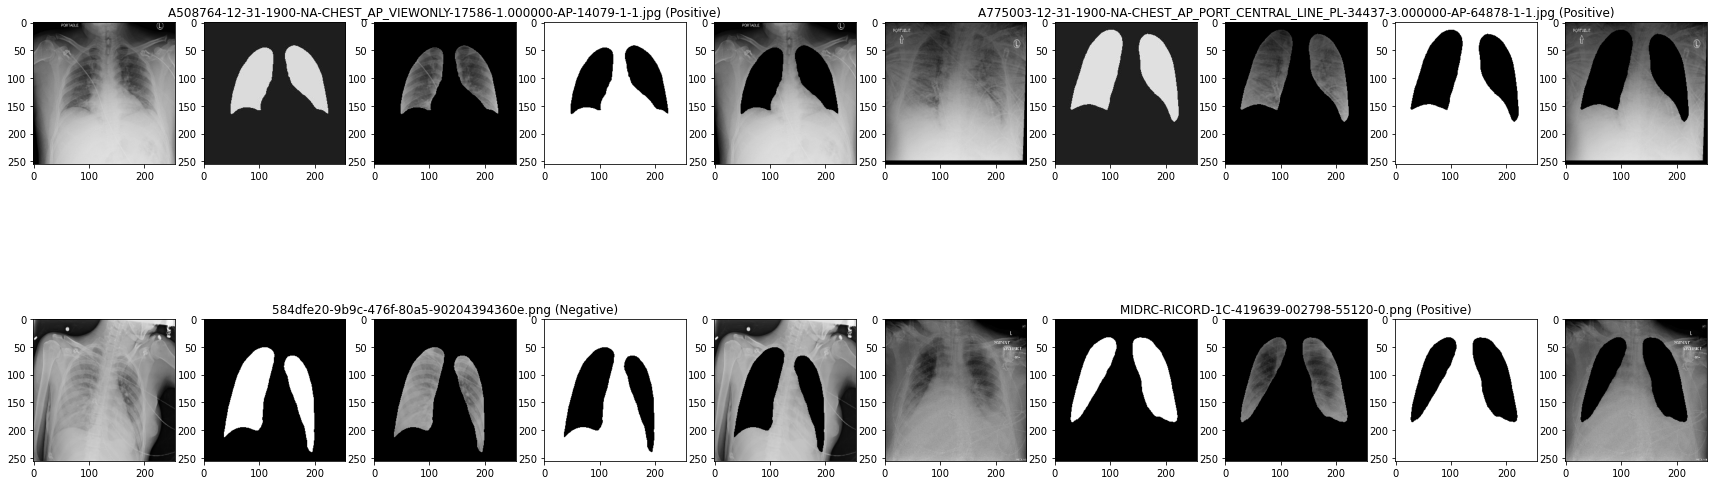

In [ ]:
val_dataset = LungImageDataset(val_set, '/mnt/DATA/covid19_resnet152_python-main/archive_14gb/COVIDxCXR3/train/', '/mnt/DATA/covid19_resnet152_python-main/archive_14gb/mainscript/segment/visualize/FPN_DenseNet121/lung_mask/', True, False)
val_dataloader = DataLoader(val_dataset, batch_size = 8, shuffle=True)
image, mask, maskthres, lung, cxrnotlung, targets, name = next(iter(val_dataloader))
# print(lung.shape)
# print(cxrnotlung.shape)
res1 = torch.transpose(lung,1,3)
# imshow_img_mask(img, mask, maskthres, lung, notlung, targets, name)
imshow_img_mask1(image, mask, maskthres, lung, cxrnotlung, targets, name)

In [ ]:
def imshow_img_mask(img, mask, label):
    """ Imshow for Tensor"""
    plt.figure(figsize = (30,10))
    for idx in range(3):
        label = ['Negative' if lb == 0 else 'Positive' for lb in targets]        

        plt.subplot(3,8, 1+idx*8)
        plt.imshow(img[4*idx], cmap='gray')
        plt.title(label[4*idx])
        plt.subplot(3,8, 2+idx*8)
        plt.imshow(mask[4*idx], cmap='gray')        

        plt.subplot(3,8,3+idx*8)
        plt.imshow(img[4*idx +1], cmap='gray')
        plt.title(label[4*idx+1])
        plt.subplot(3,8,4+idx*8)
        plt.imshow(mask[4*idx +1], cmap='gray')

        plt.subplot(3,8, 5+idx*8)
        plt.imshow(img[4*idx+2], cmap='gray')
        plt.title(label[4*idx+2])
        plt.subplot(3,8, 6+idx*8)
        plt.imshow(mask[4*idx+2], cmap='gray')

        plt.subplot(3,8, 7 +idx*8)
        plt.imshow(img[4*idx +3], cmap='gray')
        plt.title(label[4*idx+3])
        plt.subplot(3,8, 8 +idx*8)
        plt.imshow(mask[4*idx +3], cmap='gray')

    plt.savefig('../visualize/train_dataloader.png')

    plt.show()

In [ ]:
train_dataset = LungImageDataset(train_txt, '/mnt/DATA/covid19_resnet152_python-main/archive_14gb/COVIDxCXR3/train/', '/mnt/DATA/covid19_resnet152_python-main/archive_14gb/mainscript/segment/visualize/FPN_DenseNet121/lung_mask/', True, False)
train_dataloader = DataLoader(train_dataset, batch_size = 12, shuffle=True)
image, mask, maskthres, lung, cxrnotlung, targets, name = next(iter(train_dataloader))
# imshow_img_mask(image, mask, name)

In [ ]:
class DatasetPredict(Dataset):
    def __init__(self, img_folder,  transform = None): # 'Initialization'

        self.img_folder = img_folder
        self.transform = transform
  
    def __len__(self):  # 'Denotes the total number of samples'
        return len(os.listdir(self.img_folder))

    def __getitem__(self,index): # 'Generates one sample of data'      

        images_list = os.listdir(self.img_folder)
        # print(images_list)
        images_name = images_list[index]
        images = cv2.imread(self.img_folder +  images_name,0) # grey 
        # print(index)
        images = cv2.resize(images,(256,256))
        images = np.asanyarray(images, dtype=np.float32) # đoi qua numpy array kiểu float 32
        images = cv2.GaussianBlur(images, (3,3), cv2.BORDER_DEFAULT)    
        images = np.expand_dims(images,0).transpose(1,2,0)#### (256, 256, 1) 

        if self.transform != None:
            aug = self.transform(image = images)            
            images = aug['image']

        return images, images_name 

In [ ]:
def save_filename(data, path):
        ################################
    # TAO FILE TXT LUU TEN ANH #####
    ################################
    list_name =[]
    # for _, name in tqdm(dataloaderPre(opt.batch_size, transfms)['Positive']):
    for _, name in tqdm(data):
        # print(name)
        list_name.append(name)

    res = []
    # for i in tqdm(range(len(list_name)-1)):
    for idx in range(len(list_name)):
        # print(i, idx, end= ' ')
        res.append(list_name[idx])
    # 
    # for i in range(len(list_name[len(list_name)-1])): #xu li phan le trong batch cuoi
    #     res.append(list_name[len(list_name)-1][i])

    # print('res: ',len(res))

    # np.savetxt('./visualize/FPN_DenseNet121/lung_mask/Positive/filenamePos.txt', res, fmt = '%s')
    np.savetxt(path, res, fmt = '%s')

data = DatasetPredict('/mnt/DATA/covid19_resnet152_python-main/archive_14gb/COVIDxCXR3/EDA_Train/BadimgPositive/', transform = None)

loader = DataLoader(
        data, 
        batch_size=30,
        shuffle=False
        )

save_filename(data, '/mnt/DATA/covid19_resnet152_python-main/archive_14gb/COVIDxCXR3/EDA_Train/BadImagefilename.txt')

100%|██████████| 30/30 [00:00<00:00, 343.96it/s]


In [ ]:
bad_txt = pd.read_csv( '/mnt/DATA/covid19_resnet152_python-main/archive_14gb/COVIDxCXR3/EDA_Train/BadImagefilename.txt', sep=' ', header=None)
bad_txt.columns=['file_name']
bad_txt.head()

,file_name
0,A766547-01-05-1901-NA-CHEST_AP_PORT-20642-3.00...
1,A056642-12-31-1900-NA-CHEST_AP_PORT-26394-4.00...
2,A236763-01-29-1901-NA-CHEST_AP_PORT-32573-2.00...
3,A113828-01-04-1901-NA-CHEST_AP_PORT-61044-4.00...
4,A653181-01-31-1901-NA-CHEST_AP_PORT-70039-2.00...


In [ ]:
bad_txt['label'] = 'Positive'
bad_txt

,file_name,label
0,A766547-01-05-1901-NA-CHEST_AP_PORT-20642-3.00...,Positive
1,A056642-12-31-1900-NA-CHEST_AP_PORT-26394-4.00...,Positive
2,A236763-01-29-1901-NA-CHEST_AP_PORT-32573-2.00...,Positive
3,A113828-01-04-1901-NA-CHEST_AP_PORT-61044-4.00...,Positive
4,A653181-01-31-1901-NA-CHEST_AP_PORT-70039-2.00...,Positive
5,A587516-12-31-1900-NA-CHEST_AP_VIEWONLY-00217-...,Positive
6,A056642-12-31-1900-NA-CHEST_AP_PORT-26394-3.00...,Positive
7,A946387-01-08-1901-NA-CHEST_AP_VIEWONLY-96651-...,Positive
8,A586482-01-02-1901-NA-CHEST_AP_PORT-76903-5.00...,Positive
9,A536707-01-06-1901-NA-CHEST_AP_PORT-00467-1.00...,Positive


In [ ]:
class BadDataset(Dataset): # train tren Lung
    def __init__(self,csv, img_folder, mask_folder): # 'Initialization'
        self.csv=csv
        self.img_folder=img_folder
        self.mask_folder = mask_folder
    
        self.image_names=self.csv[:]['file_name']# [:] lấy hết số cột số hàng của bảng
        self.labels= np.array(self.csv[:]['label']) # note kiểu mảng int đúng không?
  
    def __len__(self):  # 'Denotes the total number of samples'
        return len(self.image_names)

    def __getitem__(self,index): # 'Generates one sample of data'
    
        image=cv2.imread(self.img_folder + self.image_names.iloc[index], 0)
        image = cv2.resize(image,(256,256))

        mask = cv2.imread(self.mask_folder + self.image_names.iloc[index], 0)
        mask = cv2.resize(mask,(256,256))


        name = self.image_names[index]
        label1 =self.labels[index]
        # label1 = torch.tensor(int(label1), dtype=torch.long) #đọc từng phần tử của mảng, chuyển từ array -> tensor; kiểu int64 tương ứng với long trong pytorch

        return image, mask, name, label1 

In [ ]:
def imshow_img_mask1(img, mask, label):
    """ Imshow for Tensor"""
    plt.figure(figsize = (30,20))
    for idx in range(6):
        # label = ['Negative' if lb == 0 else 'Positive' for lb in targets]        

        plt.subplot(6,10, 1+idx*10)
        plt.imshow(img[5*idx], cmap='gray')
        plt.title(label[5*idx])
        plt.subplot(6,10, 2+idx*10)
        plt.imshow(mask[5*idx], cmap='gray')        

        plt.subplot(6,10,3+idx*10)
        plt.imshow(img[5*idx +1], cmap='gray')
        plt.title(label[5*idx+1])
        plt.subplot(6,10,4+idx*10)
        plt.imshow(mask[4*idx +1], cmap='gray')

        plt.subplot(6,10, 5+idx*10)
        plt.imshow(img[5*idx+2], cmap='gray')
        plt.title(label[5*idx+2])
        plt.subplot(6,10, 6+idx*10)
        plt.imshow(mask[5*idx+2], cmap='gray')

        plt.subplot(6,10, 7 +idx*10)
        plt.imshow(img[5*idx +3], cmap='gray')
        plt.title(label[5*idx+3])
        plt.subplot(6,10, 8 +idx*10)
        plt.imshow(mask[5*idx +3], cmap='gray')

        plt.subplot(6,10, 9 +idx*10)
        plt.imshow(img[5*idx +4], cmap='gray')
        plt.title(label[5*idx+4])
        plt.subplot(6,10, 10 +idx*10)
        plt.imshow(mask[5*idx +4], cmap='gray')

    plt.savefig('../visualize/train_dataloader.png')

    plt.show()

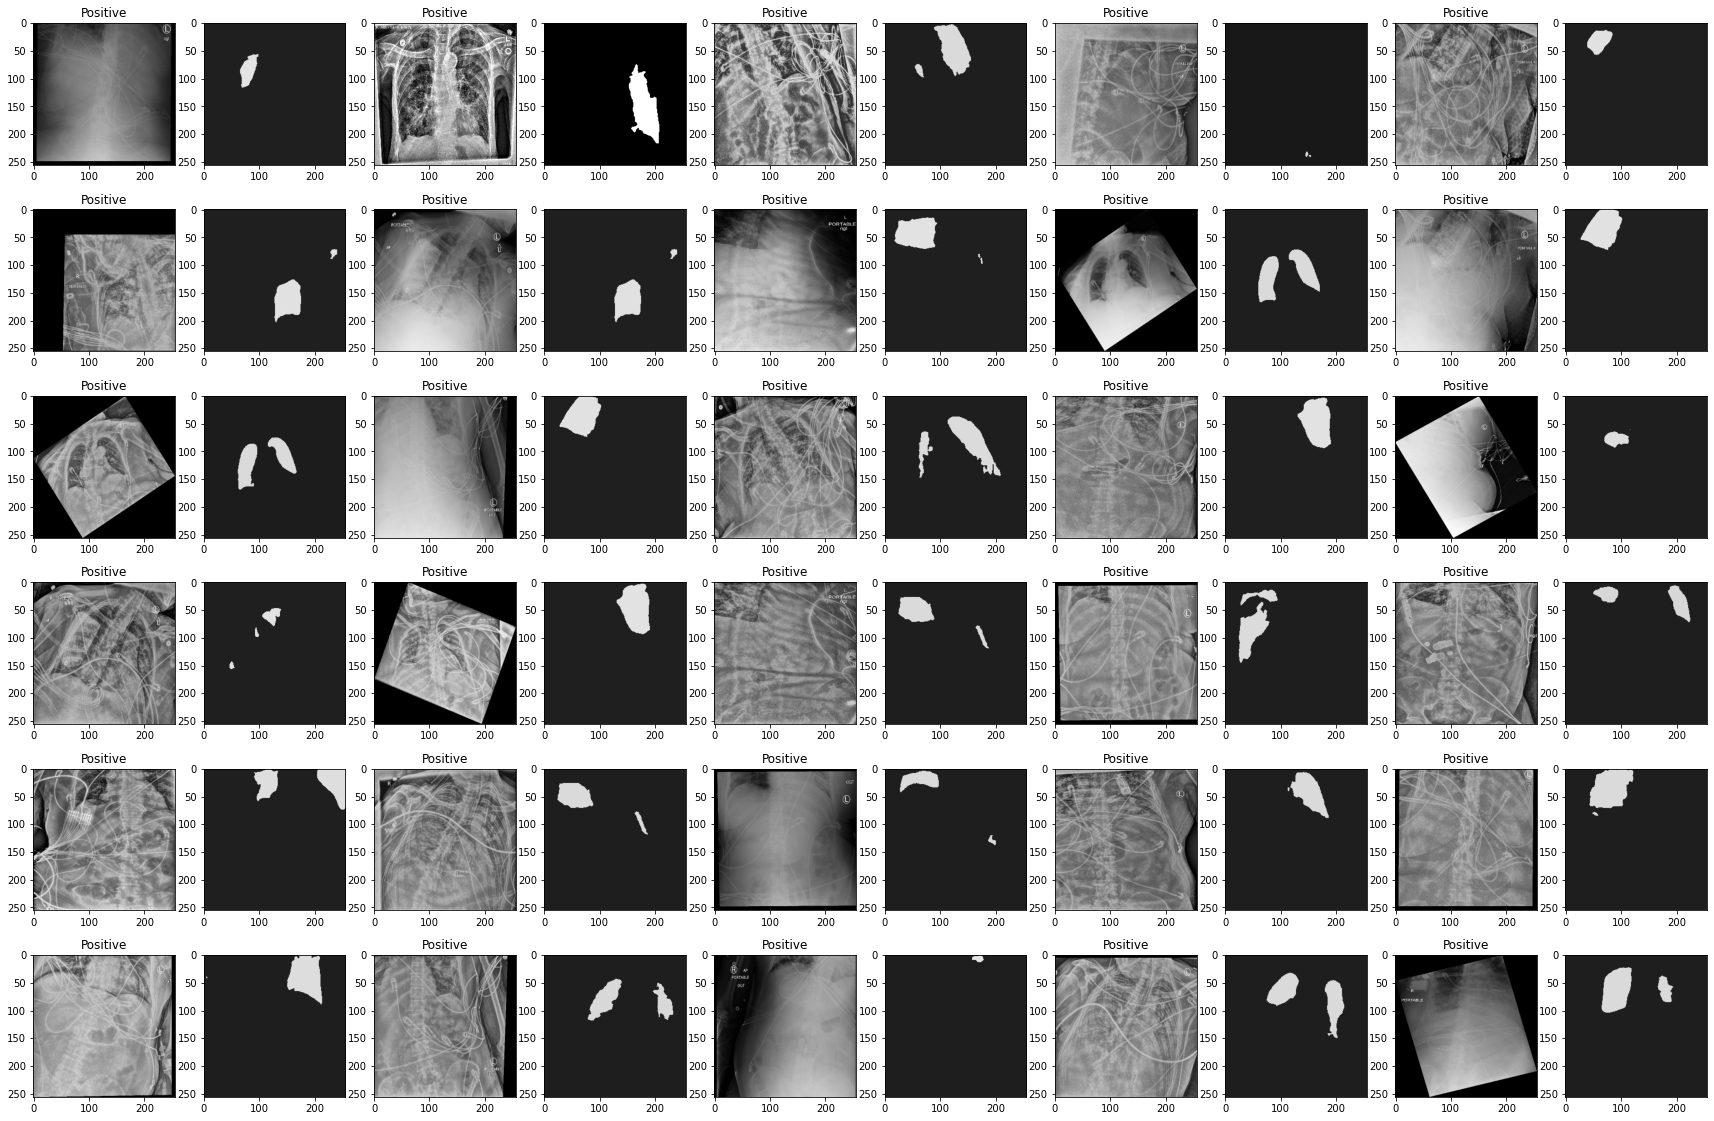

In [ ]:
bad_dataset = BadDataset(bad_txt, '/mnt/DATA/covid19_resnet152_python-main/archive_14gb/COVIDxCXR3/EDA_Train/BadimgPositive/', '/mnt/DATA/covid19_resnet152_python-main/archive_14gb/COVIDxCXR3/EDA_Train/BadmaskPositive/')
bad_dataloader = DataLoader(bad_dataset, batch_size = 30, shuffle=True)
image, mask, name, label1  = next(iter(bad_dataloader))
imshow_img_mask1(image, mask, label1)

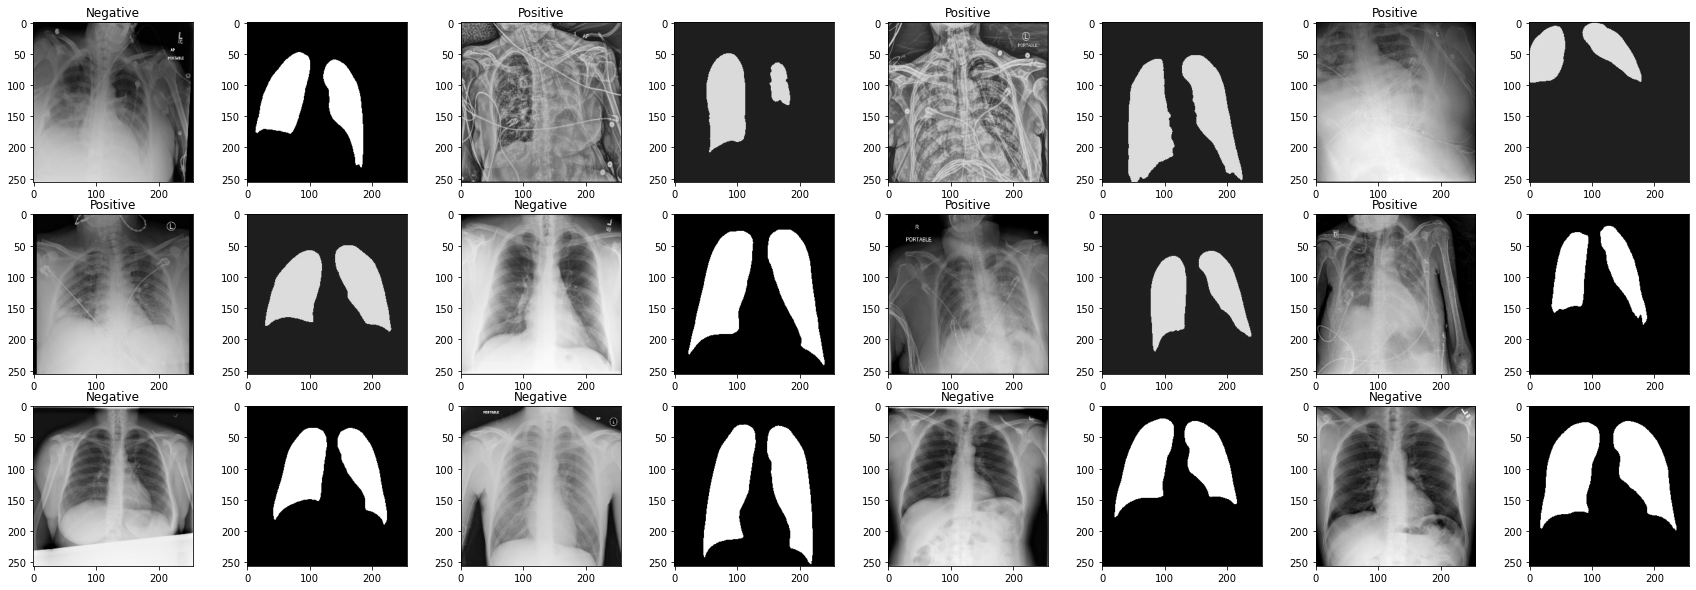

In [ ]:
bad_dataset = LungImageDataset(train_txt, '/mnt/DATA/covid19_resnet152_python-main/archive_14gb/COVIDxCXR3/train/', '/mnt/DATA/covid19_resnet152_python-main/archive_14gb/mainscript/segment/visualize/FPN_DenseNet121/lung_mask/', True, False)
train_dataloader = DataLoader(bad_dataset, batch_size = 12, shuffle=True)
image, mask, maskthres, lung, cxrnotlung, targets, name = next(iter(train_dataloader))
imshow_img_mask(image, mask, name)